In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip -q install hazm
!pip -q install arabic-reshaper
!pip install python-bidi

In [2]:
import numpy as np
np.__version__

'1.24.3'

After installing hazm restart kernel and continue

In [3]:
import hazm

In [ ]:
# pip install -q fastapi kaleido python-multipart uvicorn

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import TextVectorization
from sklearn.model_selection import train_test_split
import hazm

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from bidi.algorithm import get_display
import arabic_reshaper

##### You can download this filtered dataset (all captions lenght in this dataset between 10 - 25 token) in: 
https://drive.google.com/file/d/1ZJYc9HEbE7BkNjnvyGGNXk5pkYwXLjYI/view?usp=sharing

In [2]:
### Load dataset and images from drive in google colab
csv_path = '/content/40K-IC.csv'
img_path = '/content/drive/MyDrive/40K_IC'

In [3]:
dataset = pd.read_csv(csv_path,encoding='utf-8-sig')
dataset

,caption,image
0,<شروع> سبزیجات با یک کتاب روی کاغذ گذاشته می ش...,000000382210.jpg
1,<شروع> مردانی با کلاه سیاه در خیابان با یک پلی...,4671642676.jpg
2,<شروع> قطار زرد رنگ که دور از آسمان آبی از ریل...,000000272131.jpg
3,<شروع> چند نفر پشت آدم برفی ایستاده اند و اسکی...,000000105452.jpg
4,<شروع> دو پرنده مرده روی منقارهای متقاطع راه م...,000000005564.jpg
...,...,...
39995,<شروع> زنی با شلوارک و تی شرت در حال قدم زدن د...,000000216810.jpg
39996,<شروع> مردی در آسمان چیزی را تماشا می کند. <پا...,4759256692.jpg
39997,<شروع> عکس سیاه و سفید یک دختر نوجوان با عینک ...,000000397575.jpg
39998,<شروع> یک اتوبوس مسافربری در میامی با دوچرخه د...,000000451944.jpg


Text(0.5, 1.0, '<ﻥﺎﯾﺎﭘ> .ﺖﺳﺍ ﻩﺪﯿﺷﻮﭘ ﯽﺑﻮﺧ ﺱﺎﺒﻟ ،ﺖﺳﺍ ﺮﻈﺘﻨﻣ ﺎﻫ ﻪﻠﭘ ﯼﻭﺭ ﻪﮐ ﯼﺩﺮﻣ <ﻉﻭﺮﺷ>')

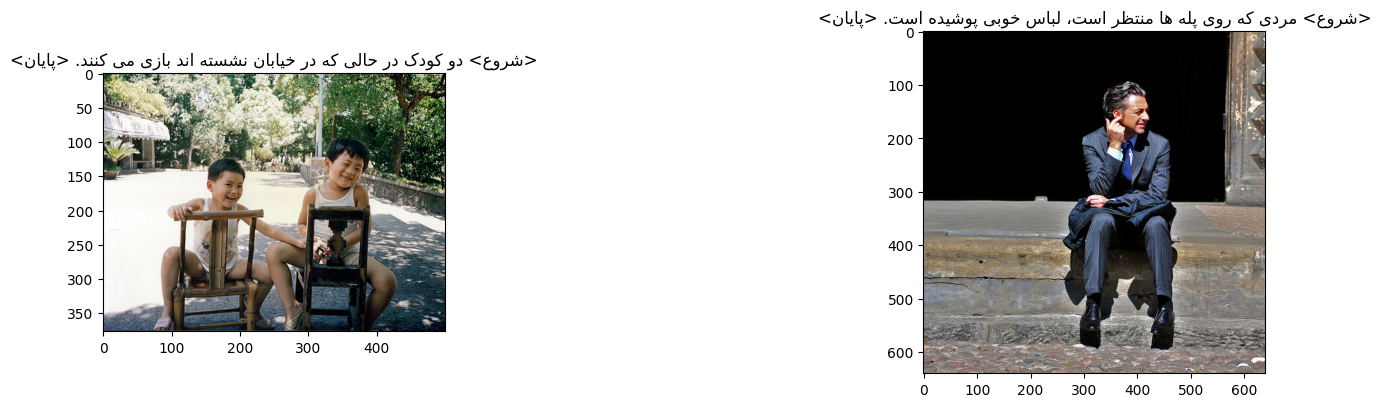

In [4]:
plt.figure(figsize=(15,12))
index = 20000
img = cv2.imread(os.path.join(img_path,dataset['image'][index]))
plt.subplot(131);plt.imshow(img[...,::-1])
text = arabic_reshaper.reshape(dataset['caption'][index])
plt.title(get_display(text))

img = cv2.imread(os.path.join(img_path,dataset['image'][index+1]))
plt.subplot(133);plt.imshow(img[...,::-1])
text = arabic_reshaper.reshape(dataset['caption'][index+1])
plt.title(get_display(text))


In [5]:
seed = 111
np.random.seed(seed)


In [6]:
dataset['caption'][0].split()

['<شروع>',
 'سبزیجات',
 'با',
 'یک',
 'کتاب',
 'روی',
 'کاغذ',
 'گذاشته',
 'می',
 'شوند',
 '<پایان>']

In [7]:
len(dataset['caption'][0])

57

In [8]:
def plot_scatter_tokens(dataset):
    token_len = dataset['caption'].apply(lambda cap:len(cap.split()))

    plt.figure(figsize=(15,5))
    plt.subplot(131)
    plt.hist(token_len, bins=30, color='green', edgecolor='white')
    plt.xlabel('Token Length')
    plt.ylabel('Frequency')
    plt.subplot(132)
    plt.boxplot(token_len)
    plt.xlabel('Token Length')
    plt.ylabel('Lenght')
    plt.subplot(133)
    plt.plot(token_len)
    plt.xlabel('Tokens')
    plt.ylabel('Lenght')

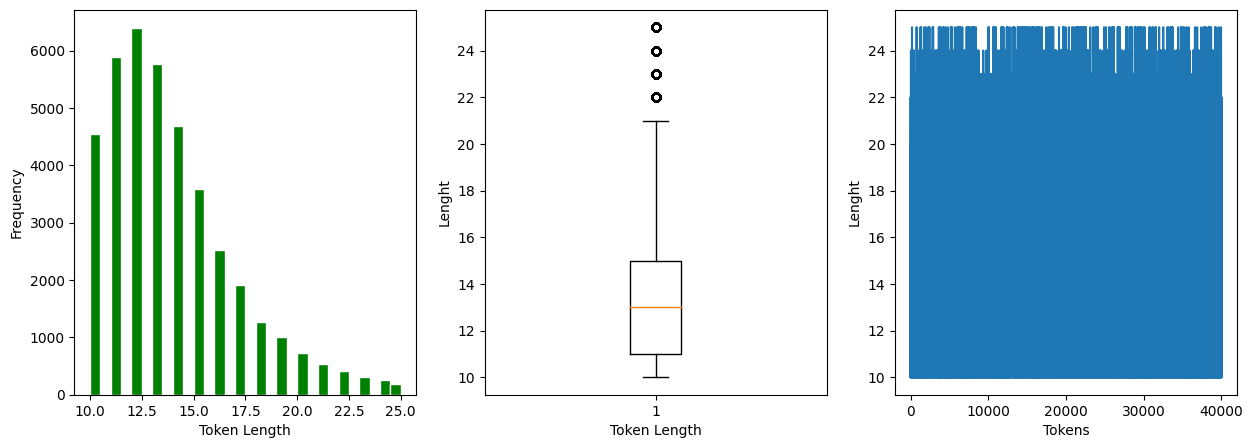

In [9]:
plot_scatter_tokens(dataset)

In [10]:
def dataset_split(df, dataset_len=40000, min_token=10, max_token=25, train_size=0.8, test_size = 0.1, shuffle=True): ## add assert if len dataset_len > filtered_dataset

    if shuffle:
        df = df.sample(frac=1).reset_index(drop=True)

    filterd_df = df[df['caption'].apply(lambda cap: min_token <= len(cap.split()) <= max_token )][:dataset_len]
    # print(len(filterd_df))

    train_size = int(dataset_len * train_size)
    test_size = int(dataset_len * test_size)

    train_df, test_valid_df = train_test_split(filterd_df,test_size=0.2,random_state=42)
    test_df, valid_df = train_test_split(test_valid_df,test_size=0.5,random_state=42)


    return train_df.reset_index(drop=True), valid_df.reset_index(drop=True), test_df.reset_index(drop=True)

In [11]:
train_df, valid_df, test_df = dataset_split(dataset,dataset_len=40000)
print("Number of training samples: ", len(train_df))
print("Number of validation samples: ", len(valid_df))
print("Number of test samples: ", len(test_df))


Number of training samples:  32000
Number of validation samples:  4000
Number of test samples:  4000


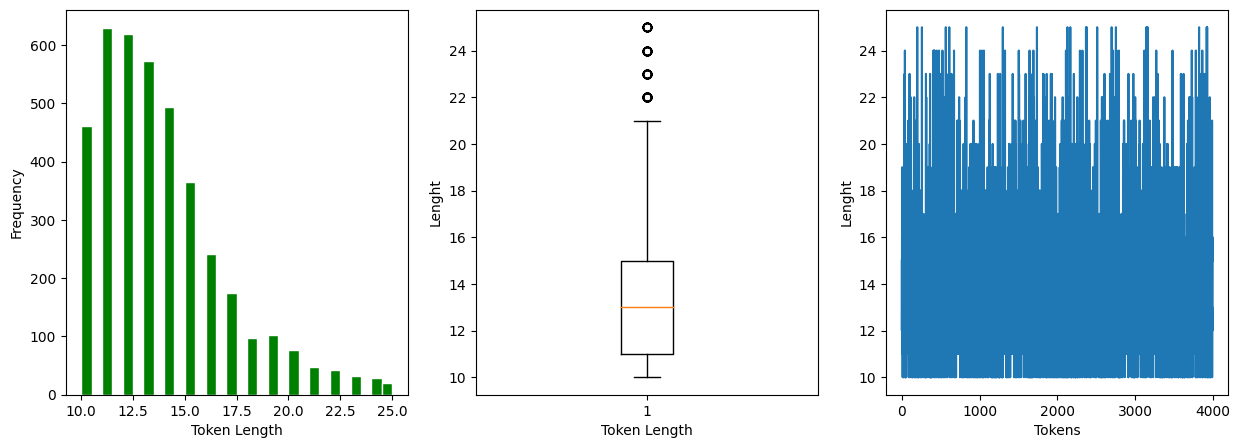

In [12]:
plot_scatter_tokens(test_df)

In [13]:
all_caption_data = dataset['caption'].str.cat()
with open('all_captions.txt','w') as file:
    file.write(all_caption_data)

In [14]:
"""
## Vectorizing the text data

We'll use the `TextVectorization` layer to vectorize the text data,
that is to say, to turn the
original strings into integer sequences where each integer represents the index of
a word in a vocabulary. We will use a custom string standardization scheme
(strip punctuation characters except `<` and `>`) and the default
splitting scheme (split on whitespace).
"""

tokenizer = hazm.WordTokenizer()
persian_tokens = tokenizer.tokenize(all_caption_data)

print('all tokens len : ', len(persian_tokens))
print('len unique tokens : ',len(set(persian_tokens)))

VOCAB_SIZE = len(set(persian_tokens))
SEQ_LENGTH = 25

vectorization = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LENGTH,
)

vectorization.adapt(persian_tokens)


all tokens len :  532308
len unique tokens :  9171


In [15]:
vocab = vectorization.get_vocabulary()
len(vocab)

9097

In [16]:
print(train_df['caption'][0])
vectorization(train_df['caption'][0])

<شروع> تختی که بالای کشوهای کمد سفید نشسته است. <پایان>


<tf.Tensor: shape=(25,), dtype=int64, numpy=
array([ 829,  651,    6,   60, 3604,  734,   22,   94,   15, 1456,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0])>

In [17]:
# Data augmentation for image data
image_augmentation = keras.Sequential(
    [
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(0.2),
        keras.layers.RandomContrast(0.3),
    ]
)

In [18]:
IMAGE_SIZE = (299,299)

def decode_image_and_vectorize(caption, path):
    read_path = os.path.join(img_path,path)
    img = tf.io.read_file(read_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)

    vcaption = vectorization(caption)

    return img, vcaption

In [19]:
"""
## Building a `tf.data.Dataset` pipeline for training

We will generate pairs of images and corresponding captions using a `tf.data.Dataset` object.
The pipeline consists of two steps:

1. Read the image from the disk
2. Tokenize all the five captions corresponding to the image
"""

os.chdir(img_path)
BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE

def decode_image_and_vectorize(caption, path):
    # read_path = os.path.join(img_path,path)
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)

    vcaption = vectorization(caption)

    return img, vcaption


def make_dataset(df):
    dataset = tf.data.Dataset.from_tensor_slices((list(df['caption']), list(df['image'])))
    dataset = dataset.shuffle(BATCH_SIZE * 8)
    dataset = dataset.map(decode_image_and_vectorize, num_parallel_calls=AUTOTUNE)

    dataset = dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

    return dataset


train_dataset = make_dataset(train_df)
valid_dataset = make_dataset(valid_df)
test_dataset = make_dataset(test_df)


In [20]:
batch = next(iter(train_dataset))
print(batch[0].shape)
print(batch[1].shape)

(64, 299, 299, 3)
(64, 25)


In [21]:
EPOCHS = 60

In [22]:
"""
## Building the model

Our image captioning architecture consists of three models:

1. A CNN: used to extract the image features
2. A TransformerEncoder: The extracted image features are then passed to a Transformer
                    based encoder that generates a new representation of the inputs
3. A TransformerDecoder: This model takes the encoder output and the text data
                    (sequences) as inputs and tries to learn to generate the caption.
"""

from keras import layers
from keras.applications import efficientnet
from TransformerModel import TransformerEncoderBlock, TransformerDecoderBlock


EMBED_DIM = 512
FF_DIM = 512

def get_cnn_model():
    base_model = efficientnet.EfficientNetB0(
        input_shape=(*IMAGE_SIZE, 3),
        include_top=False,
        weights="imagenet",
    )
    # We freeze our feature extractor
    base_model.trainable = False
    base_model_out = base_model.output
    base_model_out = layers.Reshape((-1, base_model_out.shape[-1]))(base_model_out)
    cnn_model = keras.models.Model(base_model.input, base_model_out)
    return cnn_model


cnn_model = get_cnn_model()
encoder = TransformerEncoderBlock(embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=1)
decoder = TransformerDecoderBlock(embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=2, seq_len=SEQ_LENGTH, vocab_size=VOCAB_SIZE)


In [ ]:
"""
## Building ImageCaptioningModel
"""

from ICModel import ImageCaptioningModel


caption_model = ImageCaptioningModel(
    cnn_model=cnn_model,
    encoder=encoder,
    decoder=decoder,
    image_aug=image_augmentation,
)


In [ ]:
cross_entropy = keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction="none"
)

early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)


class LRSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, post_warmup_learning_rate, warmup_steps):
        super().__init__()
        self.post_warmup_learning_rate = post_warmup_learning_rate
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        global_step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        warmup_progress = global_step / warmup_steps
        warmup_learning_rate = self.post_warmup_learning_rate * warmup_progress
        return tf.cond(
            global_step < warmup_steps,
            lambda: warmup_learning_rate,
            lambda: self.post_warmup_learning_rate,
        )
    def get_config(self):
      config = {
      # 'd_model': self.d_model
      'warmup_steps': self.warmup_steps,

      }
      return config


num_train_steps = len(train_dataset) * EPOCHS
num_warmup_steps = num_train_steps // 15
lr_schedule = LRSchedule(post_warmup_learning_rate=1e-4, warmup_steps=num_warmup_steps)

caption_model.compile(optimizer=keras.optimizers.Adam(lr_schedule), loss=cross_entropy)

In [23]:
"""
## Model training
"""
caption_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=valid_dataset,
    callbacks=[early_stopping],
)

16705208/16705208 [==============================] - 0s 0us/step
Epoch 1/60
500/500 [==============================] - 5065s 10s/step - loss: 7.6385 - acc: 0.0338 - val_loss: 5.7341 - val_acc: 0.1493
Epoch 2/60
500/500 [==============================] - 237s 474ms/step - loss: 5.2664 - acc: 0.1513 - val_loss: 4.5894 - val_acc: 0.2527
Epoch 3/60
500/500 [==============================] - 227s 454ms/step - loss: 4.3526 - acc: 0.2554 - val_loss: 3.9275 - val_acc: 0.3134
Epoch 4/60
500/500 [==============================] - 210s 419ms/step - loss: 3.8194 - acc: 0.3100 - val_loss: 3.5326 - val_acc: 0.3531
Epoch 5/60
500/500 [==============================] - 211s 422ms/step - loss: 3.4764 - acc: 0.3434 - val_loss: 3.2986 - val_acc: 0.3760
Epoch 6/60
500/500 [==============================] - 232s 464ms/step - loss: 3.2564 - acc: 0.3681 - val_loss: 3.1740 - val_acc: 0.3893
Epoch 7/60
500/500 [==============================] - 232s 463ms/step - loss: 3.1063 - acc: 0.3842 - val_loss: 3.0839 - 

#### Generate caption on test images

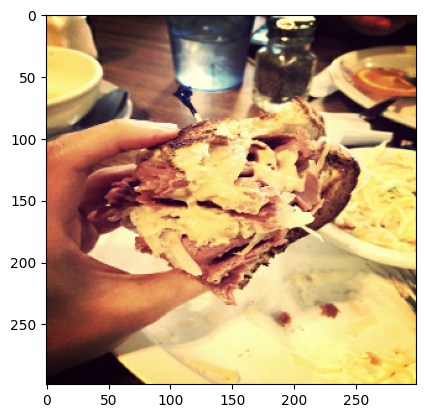

Predicted Caption:  شخصی که یک تکه پیتزا را در دست گرفته است پایان می شود پایان می کند پایان می شود پایان می کند پایان می


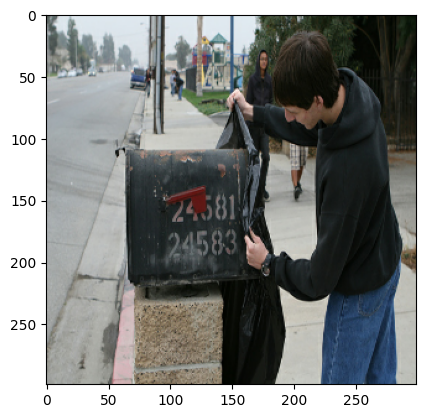

Predicted Caption:  مردی با کت و شلوار و شلوار مشکی در حال صحبت کردن با تلفن همراه پایان یک کیسه های خود است پایان می کند


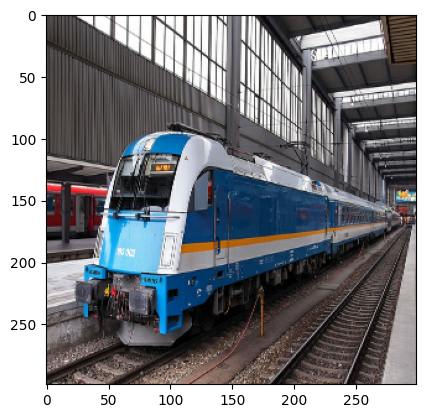

Predicted Caption:  قطاری که از روی ریل قطار در کنار ریل قطار حرکت می کند پایان می کند پایان می کند پایان می آید پایان می


In [35]:
vocab = vectorization.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = SEQ_LENGTH - 1
valid_images = list(valid_df['image'])


def generate_caption():
    sample_img = np.random.choice(valid_images)
    cap = valid_df[valid_df['image']== sample_img]['caption']

    sample_img,vcap = decode_image_and_vectorize(str(cap),sample_img)
    img = sample_img.numpy().clip(0, 255).astype(np.uint8)
    plt.imshow(img)
    plt.show()

    img = tf.expand_dims(sample_img, 0)
    img = caption_model.cnn_model(img)

    encoded_img = caption_model.encoder(img, training=False)

    decoded_caption = "<شروع> "
    for i in range(max_decoded_sentence_length):
        tokenized_caption = vectorization([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = index_lookup[sampled_token_index]
        if sampled_token == "<پایان>":
            break
        decoded_caption += " " + sampled_token

    decoded_caption = decoded_caption.replace("<شروع> ", "")
    decoded_caption = decoded_caption.replace(" <پایان>", "").strip()
    print("Predicted Caption: ", decoded_caption)


generate_caption()
generate_caption()
generate_caption()


### Continue Training

In [37]:
caption_model.fit(
    train_dataset,
    epochs=20,
    validation_data=valid_dataset,
    callbacks=[early_stopping],
)

Epoch 1/20
500/500 [==============================] - 218s 434ms/step - loss: 2.3855 - acc: 0.4673 - val_loss: 2.9099 - val_acc: 0.4247
Epoch 2/20
500/500 [==============================] - 212s 422ms/step - loss: 2.3455 - acc: 0.4718 - val_loss: 2.9145 - val_acc: 0.4239
Epoch 3/20
500/500 [==============================] - 206s 412ms/step - loss: 2.3052 - acc: 0.4765 - val_loss: 2.9299 - val_acc: 0.4222
Epoch 4/20
500/500 [==============================] - 230s 459ms/step - loss: 2.2634 - acc: 0.4828 - val_loss: 2.9344 - val_acc: 0.4230


In [38]:
caption_model.fit(
    train_dataset,
    epochs=50,
    validation_data=valid_dataset,
    callbacks=[early_stopping],
)

Epoch 1/50
500/500 [==============================] - 234s 468ms/step - loss: 2.3453 - acc: 0.4712 - val_loss: 2.9143 - val_acc: 0.4239
Epoch 2/50
500/500 [==============================] - 221s 442ms/step - loss: 2.3031 - acc: 0.4778 - val_loss: 2.9297 - val_acc: 0.4231
Epoch 3/50
500/500 [==============================] - 224s 447ms/step - loss: 2.2642 - acc: 0.4828 - val_loss: 2.9332 - val_acc: 0.4230
Epoch 4/50
500/500 [==============================] - 226s 451ms/step - loss: 2.2269 - acc: 0.4863 - val_loss: 2.9406 - val_acc: 0.4236
